# Exploring possibilities with `topojson`
Going to take a look at whether it is possible to make a topological data structure backing the tilings. Steps involved:

+ Initial exploration of converting a TileUnit to a `topojson` object and back again (i.e. retrieve the points, edges, faces) - DONE at 27/11/23
+ Look into shapely's new precision options - and generally rationalise the various hacks for keeping polygons clean - DONE 15/12/23 (keep an eye on it for errors, of course...)
+ Build said data structure from clean polgons
+ Explore 'wobbly' edge use-case

In [1]:
%matplotlib inline

from matplotlib import pyplot

from weavingspace.topology import Topology
from weavingspace import TileUnit
from weavingspace import tiling_utils

import geopandas as gpd
import pandas as pd
import shapely.geometry as geom
import shapely.affinity as affine
import shapely.ops
import math
import copy

In [2]:
tile = TileUnit(
  # tiling_type = "hex-colouring", n = 7, dissection_offset = 1
  # tiling_type = "square-colouring", n = 5, dissection_offset = 1
  # tiling_type = "hex-dissection", n = 12, dissection_offset = 0
  # tiling_type = "archimedean", code = "4.6.12"
  # tiling_type = "archimedean", code = "3.3.4.3.4"
  tiling_type = "archimedean", code = "4.4.4.4"
  # tiling_type = "archimedean", code = "4.8.8"
  # tiling_type = "cairo"
)
# tile.plot(r = 1)

In [3]:
topo = Topology(tile)

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


(-2750.0, 2750.0, -2750.0, 2750.0)

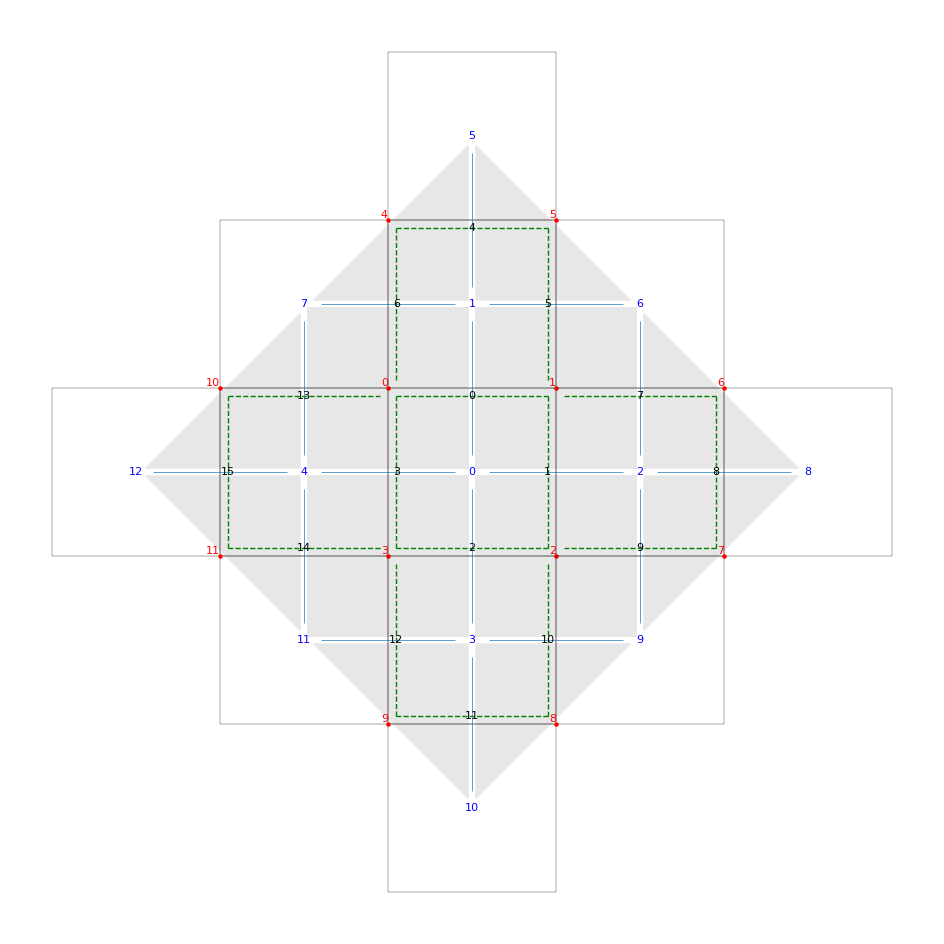

In [4]:
fig = pyplot.figure(figsize = (12, 12))
ax = fig.add_axes(111)

gpd.GeoSeries(topo.polygons).plot(ax = ax, lw = 0.25, 
                                  ec = "k", fc = "#00000000")
# gpd.GeoSeries(topo.centres).plot(ax = ax, markersize = 5, color = "dodgerblue")

for i, c in enumerate(topo.centres):
  ax.annotate(text = i, xy = (c.x, c.y), fontsize = 8, 
              color = "b", ha = "center", va = "center")

v_ids = [i for i, v in enumerate(topo.vertices) 
         if len(topo.vertex_polygons[i]) > 2]
vertices = gpd.GeoSeries([topo.vertices[i] for i in v_ids])
vertices.plot(ax = ax, color = "r", markersize = 5)
for i, v in zip(v_ids, vertices):
  ax.annotate(text = i, xy = (v.x, v.y), fontsize = 8, color = "r",
              ha = "right", va = "bottom")

edges = gpd.GeoSeries(
  [affine.scale(geom.LineString(
    [topo.vertices[topo.edges[i][0]], topo.vertices[topo.edges[i][1]]]).parallel_offset(50, side = "right"), 0.9, 0.9) 
    for i in range(len(topo.edges)) if i in topo.lefts and i in topo.rights])
edges.plot(ax = ax, color = "g", ls = "dashed", lw = 1)
for i, e in enumerate(edges):
  ax.annotate(text = i, xy = (e.centroid.x, e.centroid.y), fontsize = 8,
              ha = "center", va = "center")
  
dual = gpd.GeoSeries(
  [affine.scale(geom.LineString([topo.centres[topo.lefts[i]], topo.centres[topo.rights[i]]]), 0.8, 0.8) 
   for i in range(len(topo.edges)) if i in topo.lefts and i in topo.rights])
dual.plot(ax = ax, lw = 0.5)

dual_faces = gpd.GeoSeries(
  [geom.Polygon([topo.centres[i] for i in p]).buffer(-20) 
   for p in [topo.vertex_polygons[i] for i in v_ids]]
)
dual_faces.plot(ax = ax, fc = "#00000018")

pyplot.axis("off")

In [5]:
topo.vertex_neighbours

([10, 4, 1, 3],
 [0, 5, 6, 2],
 [3, 1, 7, 8],
 [11, 0, 2, 9],
 [15, 12, 5, 0],
 [4, 13, 14, 1],
 [1, 14, 16, 7],
 [2, 6, 17, 18],
 [9, 2, 18, 19],
 [21, 3, 8, 20],
 [22, 15, 0, 11],
 [23, 10, 3, 21],
 [13, 4],
 [12, 5],
 [5, 6],
 [4, 10],
 [6, 17],
 [7, 16],
 [8, 7],
 [20, 8],
 [9, 19],
 [11, 9],
 [10, 23],
 [22, 11])